# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [328]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep= ';')


# Load in the feature summary file.
feat_info =  pd.read_csv('AZDIAS_Feature_Summary.csv', sep= ';')




In [134]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

def shape_df(df):

    rows_az, cols_az= df.shape
    print('number of rows  is {}'.format(rows_az))
    print('number of columns is {}\n'.format(cols_az))








In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
shape_df(azdias)

number of rows in azdias is 891221
number of columns in azdias is 85



In [44]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [45]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [46]:
rows_f, cols_f= feat_info.shape

print('number of rows in feat_info {}:'.format(rows_f))
print('number of columns in feat_info {}:\n'.format(cols_f))
feat_info.head()

number of rows in feat_info 85:
number of columns in feat_info 4:



,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info= feat_info.replace('[-1,0]', np.nan)
print(feat_info)



                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical                NaN
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical                NaN
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [7]:
feat_info.isnull().sum()


attribute              0
information_level      0
type                   0
missing_or_unknown    16
dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Percentage of missing data in each column of the dataset.

missing_values_c= (azdias.isnull().sum()).sort_values(ascending= False)
print(missing_values_c[:10])


KK_KUNDENTYP    584612
KBA05_ANTG1     133324
KBA05_ANTG2     133324
KBA05_ANTG3     133324
KBA05_ANTG4     133324
KBA05_BAUMAX    133324
KBA05_GBZ       133324
MOBI_REGIO      133324
REGIOTYP        121196
KKK             121196
dtype: int64


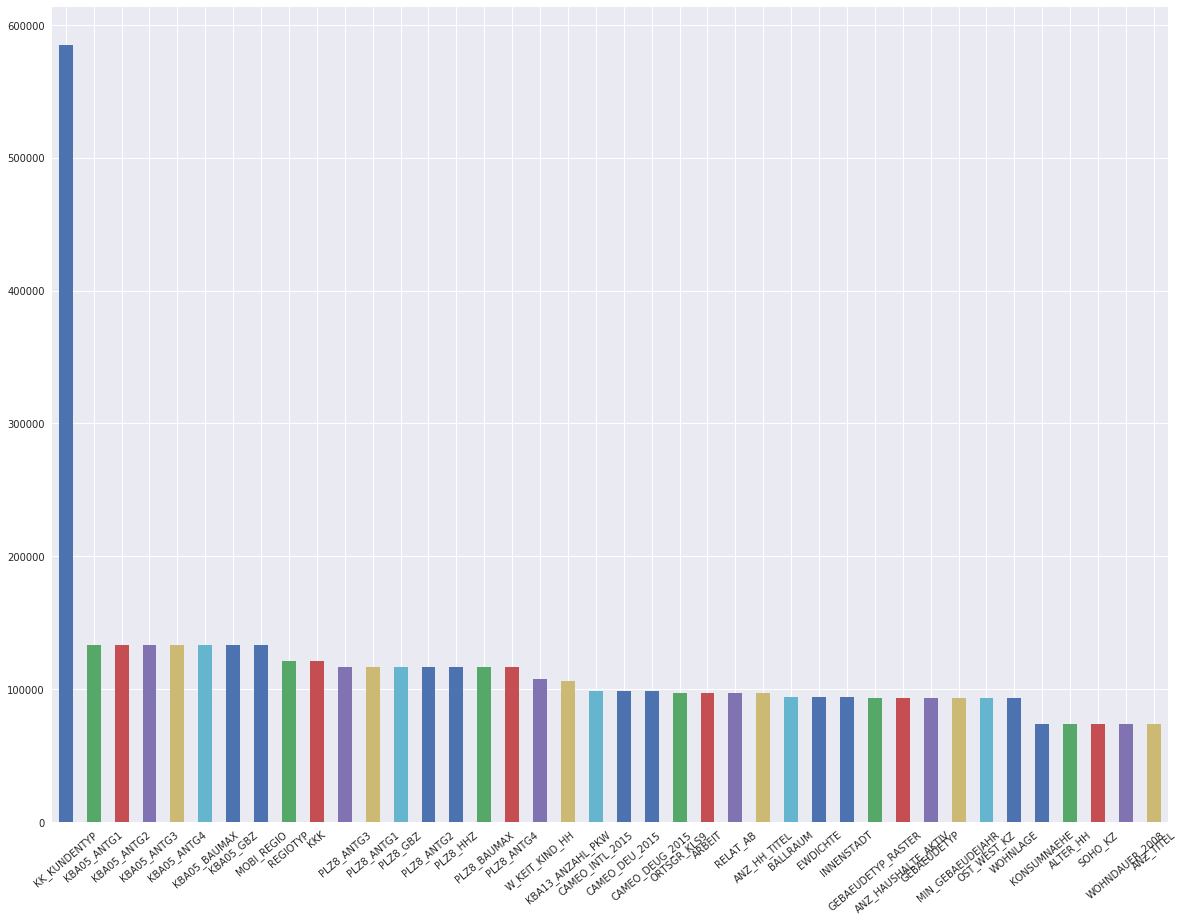

In [9]:
# Investigate patterns in the amount of missing data in each column.

sns.set()
missing_values_c[:40].plot.bar()
sns.set(rc={'figure.figsize':(30,15)})
plt.xticks(rotation = 40)
plt.xlabel='Columns in Azdias'
plt.ylabel='Amount of NaN Values'

In [9]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

to_be_removed=missing_values_c[missing_values_c > 130000].index

azdias.drop(columns= to_be_removed, axis=1, inplace= True)

shape_df(azdias)

number of rows in azdias is 891221
number of columns in azdias is 77



#### Discussion 1.1.2: Assess Missing Data in Each Column

There are a few outlier columns in the dataset. I have decided to drop any column that has more than 130000 NANs

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [10]:
# How much data is missing in each row of the dataset?

missing_values_r= azdias.isnull().sum(axis=1).sort_values(ascending= False)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

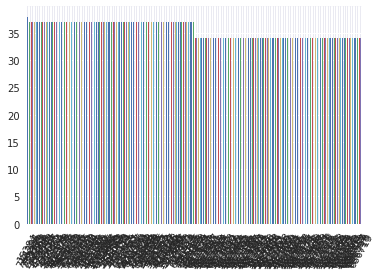

In [486]:
sns.set()
missing_values_r[:200].plot.bar()
sns.set(rc={'figure.figsize':(40,15)})
plt.xticks(rotation = 60)

In [11]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias1= missing_values_r[ missing_values_r > 32 ]
azdias2= missing_values_r[missing_values_r < 32]


print('Rows with more than 32 NaNs is {} % of the data \n'.format(round(azdias1.shape[0]/azdias.shape[0]*100)))

azdias1.to_frame()



Rows with more than 32 NaNs is 8 % of the data 



,0
15284,38
716386,37
44204,37
713399,37
732775,37
238166,37
22962,37
130318,37
5099,37
813548,37


In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# choose 5 columns where missing values are low

l_col= missing_values_c[missing_values_c < 10000].index[:5]

print(l_col.size)

5


In [13]:
def compare_subsets(column):
    """
    INPUT: Dataframe
    OTPUT: Shape of Dataframe
    """
    
    ax1=plt.subplot(2, 2, 1)
    ax1.set_title('Missing Values are more than 32')

    ax2=plt.subplot(2, 2, 2)
    ax2.set_title('Missing Values are less than 32')
    
    sns.countplot(azdias.loc[azdias1.index,column],ax=ax1)            
    sns.countplot(azdias.loc[azdias2.index,column],ax=ax2)
    
    plt.show()


        

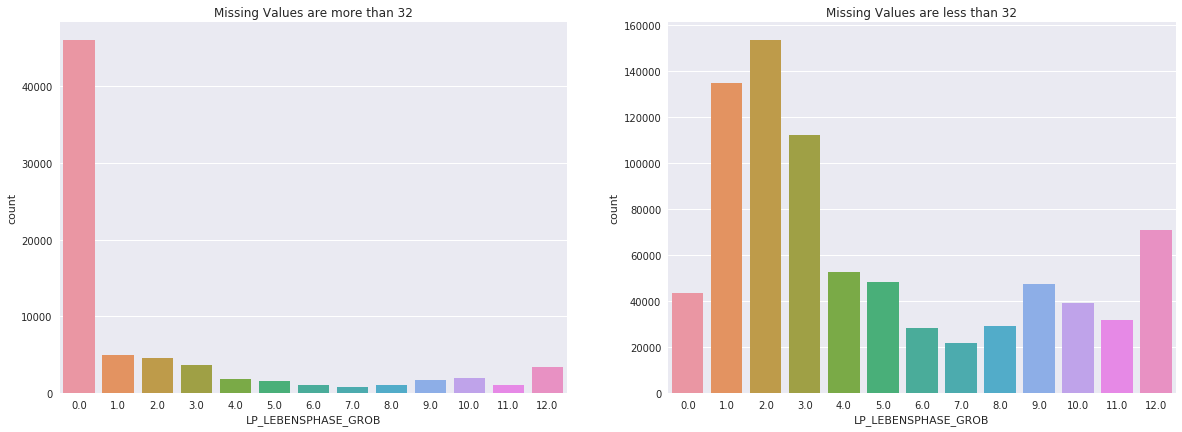

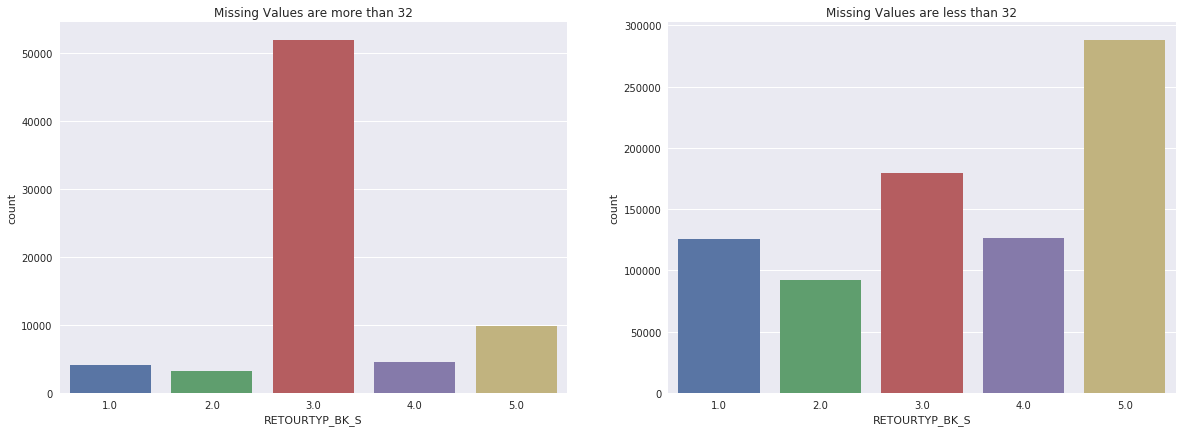

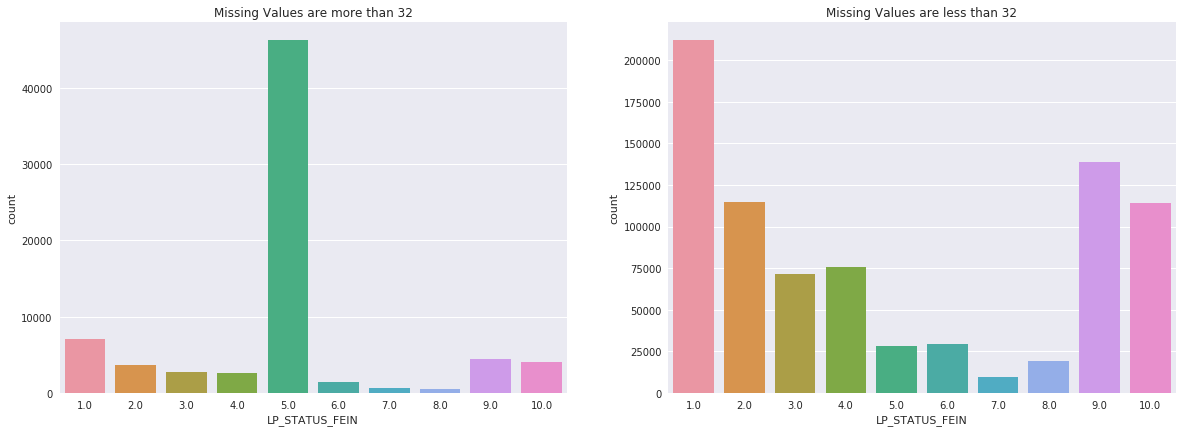

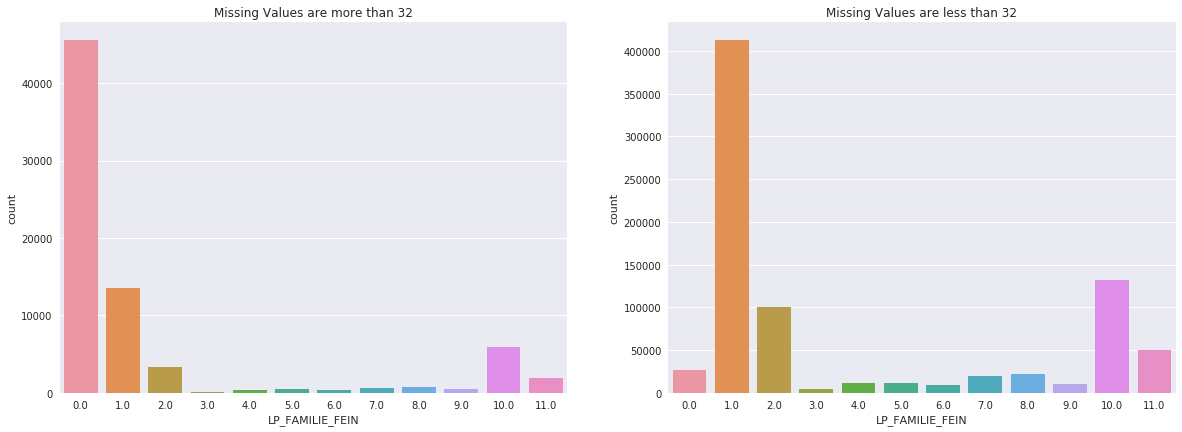

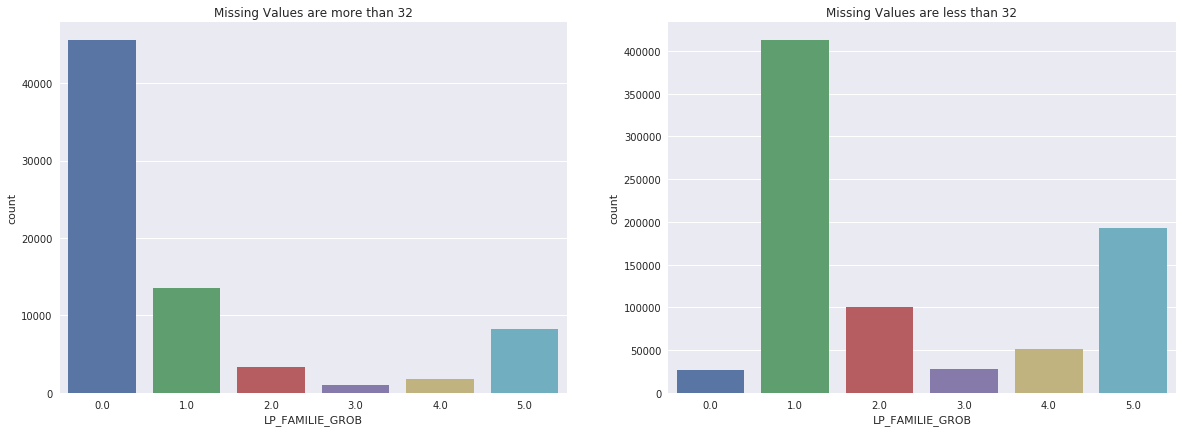

In [23]:
#Plot 

for i in range(l_col.size):
        compare_subsets(l_col[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

Number of rows where missing values are higher than 32 in the dataset makes around 8% of the dataset and as Shown by the figures above, the graphs of higher number of missing rows do not make up the much of the dataset and yet have a significant number of NaNs. Henceforth, further calculations in this notebook should be made on the second dataset.

In [14]:
# drop rows where NaN are higher than 32

azdias= azdias.drop(labels= azdias1.index, axis=0)
shape_df(azdias)

number of rows in azdias is 817622
number of columns in azdias is 77



In [15]:
#fill NaNs 

azdias =azdias.fillna(azdias.mode().iloc[0])

In [16]:
shape_df(azdias)

number of rows in azdias is 817622
number of columns in azdias is 77



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?

feat_info=feat_info[feat_info.attribute.isin(azdias.columns)]

print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical                NaN
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical                NaN
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [18]:

feat_info.type.value_counts()

ordinal        43
categorical    20
numeric         7
mixed           6
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ_data= feat_info[feat_info.type=='categorical']
azdias[categ_data.attribute]


,AGER_TYP,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,-1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1,3,1.0,0.0,2,5,8.0,W,8,8A
2,-1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1,2,0.0,0.0,1,5,1.0,W,4,4C
3,2,2,2.0,6,1.0,0,0.0,0.0,9.0,4.0,1,1,0.0,0.0,1,3,1.0,W,2,2A
4,-1,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1,2,0.0,0.0,2,4,1.0,W,6,6B
5,3,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1,0,0.0,0.0,2,4,1.0,W,8,8C
6,-1,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1,1,0.0,0.0,1,4,1.0,W,4,4A
7,-1,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1,0,0.0,0.0,1,1,8.0,W,2,2D
8,-1,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1,3,0.0,0.0,2,6,3.0,W,1,1A
9,-1,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1,3,0.0,0.0,2,4,3.0,W,1,1E
10,0,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1,2,0.0,0.0,2,3,1.0,W,9,9D


In [20]:
categ_data.attribute

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [21]:
binary_categ=[]
multi_level_categ=[]

for i in categ_data.attribute:
    if azdias[i].nunique()==2:
        binary_categ.append(i)
    else:
        multi_level_categ.append(i)
        
binary_categ, multi_level_categ

(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ'],
 ['AGER_TYP',
  'CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'TITEL_KZ',
  'VERS_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015'])

In [22]:
for j in binary_categ:
    print(azdias[j].value_counts())

2    426622
1    391000
Name: ANREDE_KZ, dtype: int64
0    642397
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    810734
1.0      6888
Name: SOHO_KZ, dtype: int64
W    649077
O    168545
Name: OST_WEST_KZ, dtype: int64


In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Re-encode multi-level categories using get_dummies

azdias= pd.get_dummies(data=azdias,columns=multi_level_categ)


In [24]:
# Manually Re-encoding binary-level categories

azdias['ANREDE_KZ'].replace({2:0,1:1},inplace=True)
azdias['SOHO_KZ'].replace({0.0:0,1.0:1},inplace=True)
azdias['OST_WEST_KZ'].replace({'W':0,'O':1},inplace=True)
azdias['OST_WEST_KZ'].astype('int',inplace=True)



1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
20        0
21        0
22        0
23        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
         ..
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: OST_WEST_KZ, Length: 817622, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

For binary categorial features, I decided to encode them manually. I also decided to keep the multi-level categorical features and encode them using Panda's .get_dummies. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [26]:
azdias['PRAEGENDE_JUGENDJAHRE'].head()

1    14
2    15
3     8
4     8
5     3
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

You can call these azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] and azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] or anything else which makes sense.

For Decade, you can have a dictionary that maps the value, say 2, to the correct decade as a number which is 40. For Movement, you can create a Boolean variable where 1 and 0 indicate different values.

You can use any common pandas function such as map or apply to assign values to these new columns based on the values in the given column.



In [25]:
# Create a dictionary to map decades where 40s = 1st Decade, 50s= 2nd Decade...etc
decade= {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5,11:5,12:5,13:5, 14:6, 15:6}

# Create a dictionary to map movement where Mainstream = 0, Avantgarde= 1
movement={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

In [26]:
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias.PRAEGENDE_JUGENDJAHRE 
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias.PRAEGENDE_JUGENDJAHRE
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade, inplace=True) 
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement, inplace=True) 

# drop original column
azdias.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)

shape_df(azdias)

number of rows in azdias is 817622
number of columns in azdias is 210



### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [28]:
financial_status= {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4
                  ,44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}

family_type={11:1, 12: 2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3
                  ,44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5 }

azdias['CAMEO_INTL_2015_FINANCIAL_STATUS']= azdias.CAMEO_INTL_2015 
azdias['CAMEO_INTL_2015_FAMILY_TYPE'] = azdias.CAMEO_INTL_2015
azdias['CAMEO_INTL_2015_FINANCIAL_STATUS'].replace(financial_status, inplace=True) 
azdias['CAMEO_INTL_2015_FAMILY_TYPE'].replace(family_type, inplace=True) 


azdias.drop('CAMEO_INTL_2015',axis=1,inplace=True)


In [29]:
shape_df(azdias)

number of rows in azdias is 817622
number of columns in azdias is 211



#### Discussion 1.2.2: Engineer Mixed-Type Features


I used a dictionary to divide the data of the column into 2 parts. for the first column: 'PRAEGENDE_JUGENDJAHRE', I created two dictionaries. One for decade and one for movement. the first dictionary maped the value of the decade "40s", "50s" to 1, 2... etc. I did the same thing with the movement dictionary. Then I created 2 new columns mapping the values of each dictionary, separating the data. Finally, I dropped the original column as it's of no use now.

For the second column: 'CAMEO_INTL_2015', I followed the same method. The data was divided into two parts. The first, the financial status of a family which was divided into 5 categories, henceforth I created a dictionary mapping the values of the column to those 5 categories, creating a new column. The second part of the data, described what type of family it is, also divided into 5 categories. I created a dictionary and followed the same method.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [30]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

mixed_categ =feat_info[feat_info.type=="mixed"]
for mixed_feature in mixed_categ["attribute"]:
    if mixed_feature in azdias.columns:
        azdias.drop(mixed_feature,axis=1,inplace=True)

In [31]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

shape_df(azdias)

number of rows in azdias is 817622
number of columns in azdias is 207



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [255]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    
    # remove 7 columns containing highest values of NaN
    
    shape_df(df)
    
    missing_values_col= (df.isnull().sum()).sort_values(ascending= False).to_frame()
    to_be_removed= missing_values_col.index[:7]
    df.drop(columns=df[to_be_removed] , axis=1, inplace= True)

    shape_df(df)
    
    
    #remove rows rows, ...
    
    
    missing_values_row= df.isnull().sum(axis=1).sort_values(ascending= False)
    df1= missing_values_row[ missing_values_row > 32 ]
    df= df.drop(labels= df1.index, axis=0)
    shape_df(df)
    
    #fill NaNs
    df =df.fillna(df.mode().iloc[0])
    
    feat_info= feat_info.replace('[-1,0]', np.nan)
    feat_info=feat_info[feat_info.attribute.isin(df.columns)]
    categ_data= feat_info[feat_info.type=='categorical']

    binary_categ=[]
    multi_level_categ=[]
    
    for i in categ_data.attribute:
        print(i)
        print(df[i])
        if df[i].nunique()==2:
            binary_categ.append(i)
        else:
            multi_level_categ.append(i)
    
    df= pd.get_dummies(data=df,columns=multi_level_categ)     
    
    for j in range(len(binary_categ)):
        #print(j)
        #print(df[binary_categ[j]])
        #print(df[j])
        lst= df[binary_categ[j]].value_counts().index.tolist()
        df[binary_categ[j]].replace({lst[0]:0,lst[1]:1},inplace=True)
        print('{} and {} have been replaced'.format(lst[0], lst[1])) 
    
    
  
    
    df.drop('CAMEO_INTL_2015',axis=1,inplace=True)
    
    df.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
  
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [198]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias.isnull().sum().sum()


0

In [199]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817622 entries, 1 to 891220
Columns: 207 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_FAMILY_TYPE
dtypes: float64(29), int64(28), object(2), uint8(148)
memory usage: 489.7+ MB


In [200]:
azdias.dtypes

ALTERSKATEGORIE_GROB                  int64
ANREDE_KZ                             int64
FINANZ_MINIMALIST                     int64
FINANZ_SPARER                         int64
FINANZ_VORSORGER                      int64
FINANZ_ANLEGER                        int64
FINANZ_UNAUFFAELLIGER                 int64
FINANZ_HAUSBAUER                      int64
GEBURTSJAHR                           int64
GREEN_AVANTGARDE                      int64
HEALTH_TYP                            int64
RETOURTYP_BK_S                      float64
SEMIO_SOZ                             int64
SEMIO_FAM                             int64
SEMIO_REL                             int64
SEMIO_MAT                             int64
SEMIO_VERT                            int64
SEMIO_LUST                            int64
SEMIO_ERL                             int64
SEMIO_KULT                            int64
SEMIO_RAT                             int64
SEMIO_KRIT                            int64
SEMIO_DOM                       

In [201]:
azdias['CAMEO_INTL_2015_FINANCIAL_STATUS']=pd.to_numeric(azdias['CAMEO_INTL_2015_FINANCIAL_STATUS'], errors='coerce' )
azdias['CAMEO_INTL_2015_FAMILY_TYPE']=pd.to_numeric(azdias['CAMEO_INTL_2015_FAMILY_TYPE'], errors='coerce' )

In [202]:
azdias =azdias.fillna(azdias.mode().iloc[0])

In [203]:
azdias.isnull().sum().sum()

0

In [50]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817622 entries, 1 to 891220
Columns: 207 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_FAMILY_TYPE
dtypes: float64(31), int64(28), uint8(148)
memory usage: 489.7 MB


In [388]:
# Apply feature scaling to the general population demographics data.
def scale_features(df):
    scaler =StandardScaler()
    scaled_features=scaler.fit_transform(df)
    scaled_features=pd.DataFrame(scaled_features,columns=df.columns.tolist())

    return scaler, scaled_features

In [390]:
scaler, azdias_scaled= scale_features(azdias)
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_FINANCIAL_STATUS,CAMEO_INTL_2015_FAMILY_TYPE
0,-1.680051,-0.957341,-1.509204,1.539713,-1.045507,1.454726,0.939208,1.357817,0.829441,-0.522271,...,-0.160535,-0.187177,-0.17755,-0.190363,-0.088675,-0.021364,1.105857,0.587622,1.067285,1.067285
1,0.169785,-0.957341,-1.509204,0.865849,-1.773009,-0.581287,0.226075,1.357817,0.811724,1.914713,...,-0.160535,-0.187177,-0.17755,-0.190363,-0.088675,-0.021364,1.105857,-1.701774,-0.851578,-0.851578
2,1.094703,-0.957341,0.666389,-0.481879,1.137001,-0.581287,-1.200193,-0.766009,0.788795,-0.522271,...,-0.160535,-0.187177,-0.17755,-0.190363,-0.088675,-0.021364,-0.089185,0.587622,-1.704406,-1.704406
3,0.169785,1.044560,0.666389,0.191985,0.409498,-1.259958,0.226075,-0.766009,0.795048,-0.522271,...,-0.160535,-0.187177,-0.17755,-0.190363,-0.088675,-0.021364,-0.089185,0.587622,0.498733,0.498733
4,-1.680051,-0.957341,-0.058809,-1.155743,1.137001,-0.581287,-0.487059,1.357817,0.774204,-0.522271,...,-0.160535,-0.187177,-0.17755,-0.190363,-0.088675,-0.021364,-1.284227,0.587622,1.280492,1.280492


### Discussion 2.1: Apply Feature Scaling

I made sure that my dataset has no missing values and then I used a standard scaler to scale my data as shown above.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [206]:
# Apply PCA to the data.

def apply_pca(df_scaled):
    pca= PCA()
    df_pca= pca.fit_transform(df_scaled)
    
    return pca, df_pca

In [207]:
pca, X_pca= apply_pca(azdias_scaled)

In [208]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pc4a - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

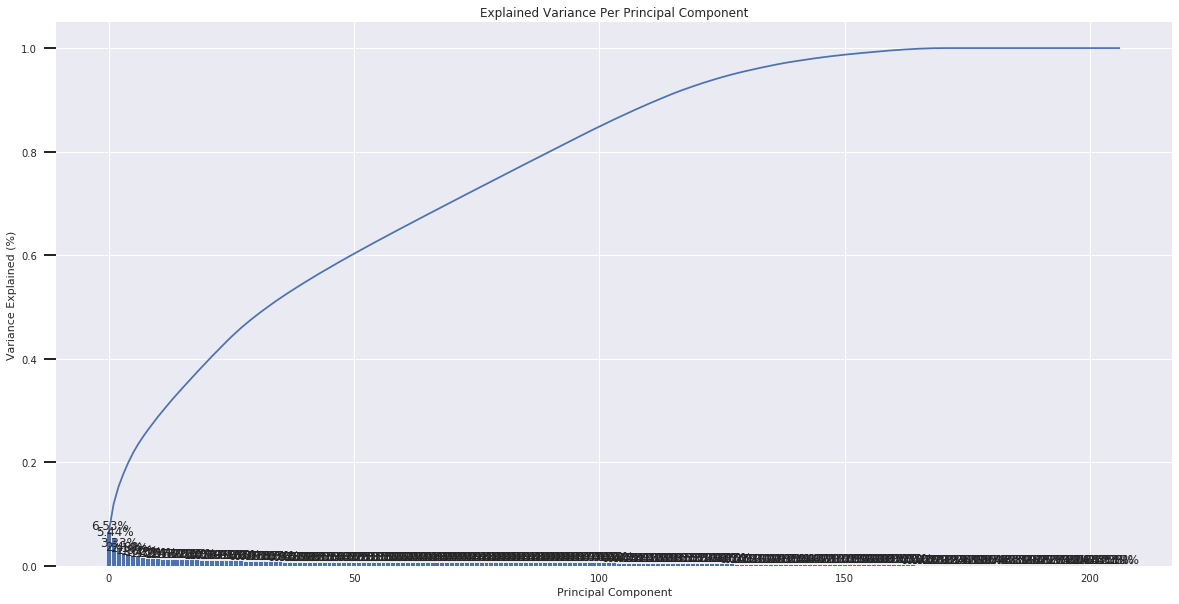

In [56]:

scree_plot(pca)

In [209]:
def apply_pca2(n_components, df_scaled):
    pca_mod= PCA(n_components)
    df_pca= pca_mod.fit_transform(df_scaled)
    
    return pca_mod, df_pca

In [210]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, X_pca= apply_pca2(75, azdias_scaled)

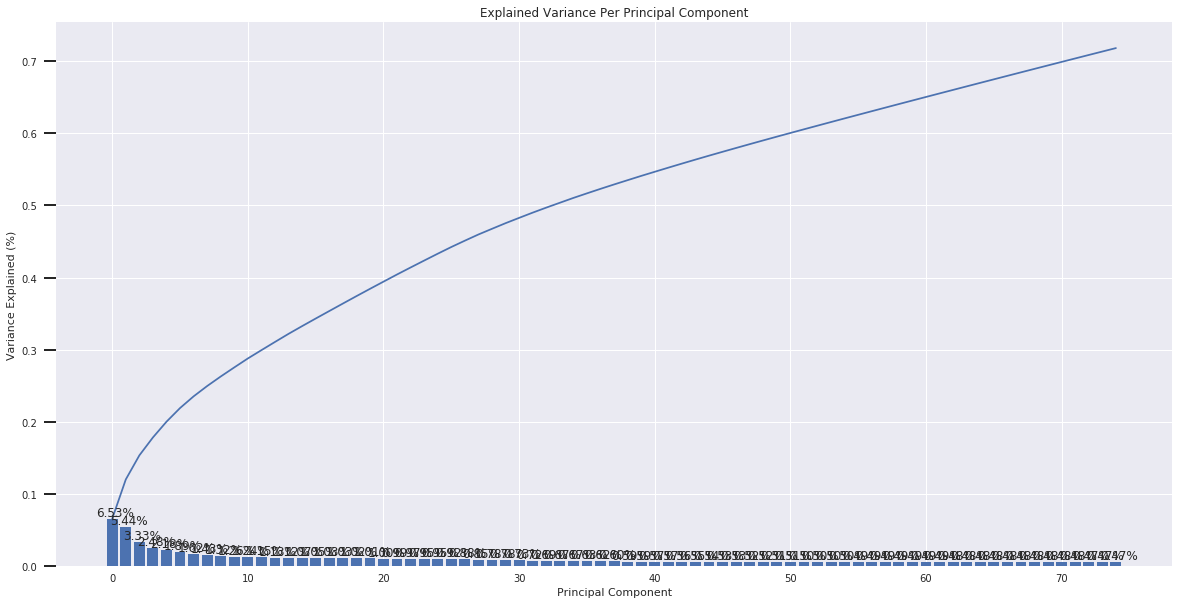

In [63]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

There are 200 components within this data. The figures show that only the first 75 have the most significant impact on the data, henceforth, I will be moving forward with those.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [211]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def PCA_weights(df,pca, n ):
    weights_df= pd.DataFrame(pca.components_, columns= list(df.columns)).iloc[n][:20]
    weights_df.sort_values(ascending=False, inplace= True)
    
    weights_df.plot(kind='bar', title= ' Component ')
    plt.show()
    
    return weights_df

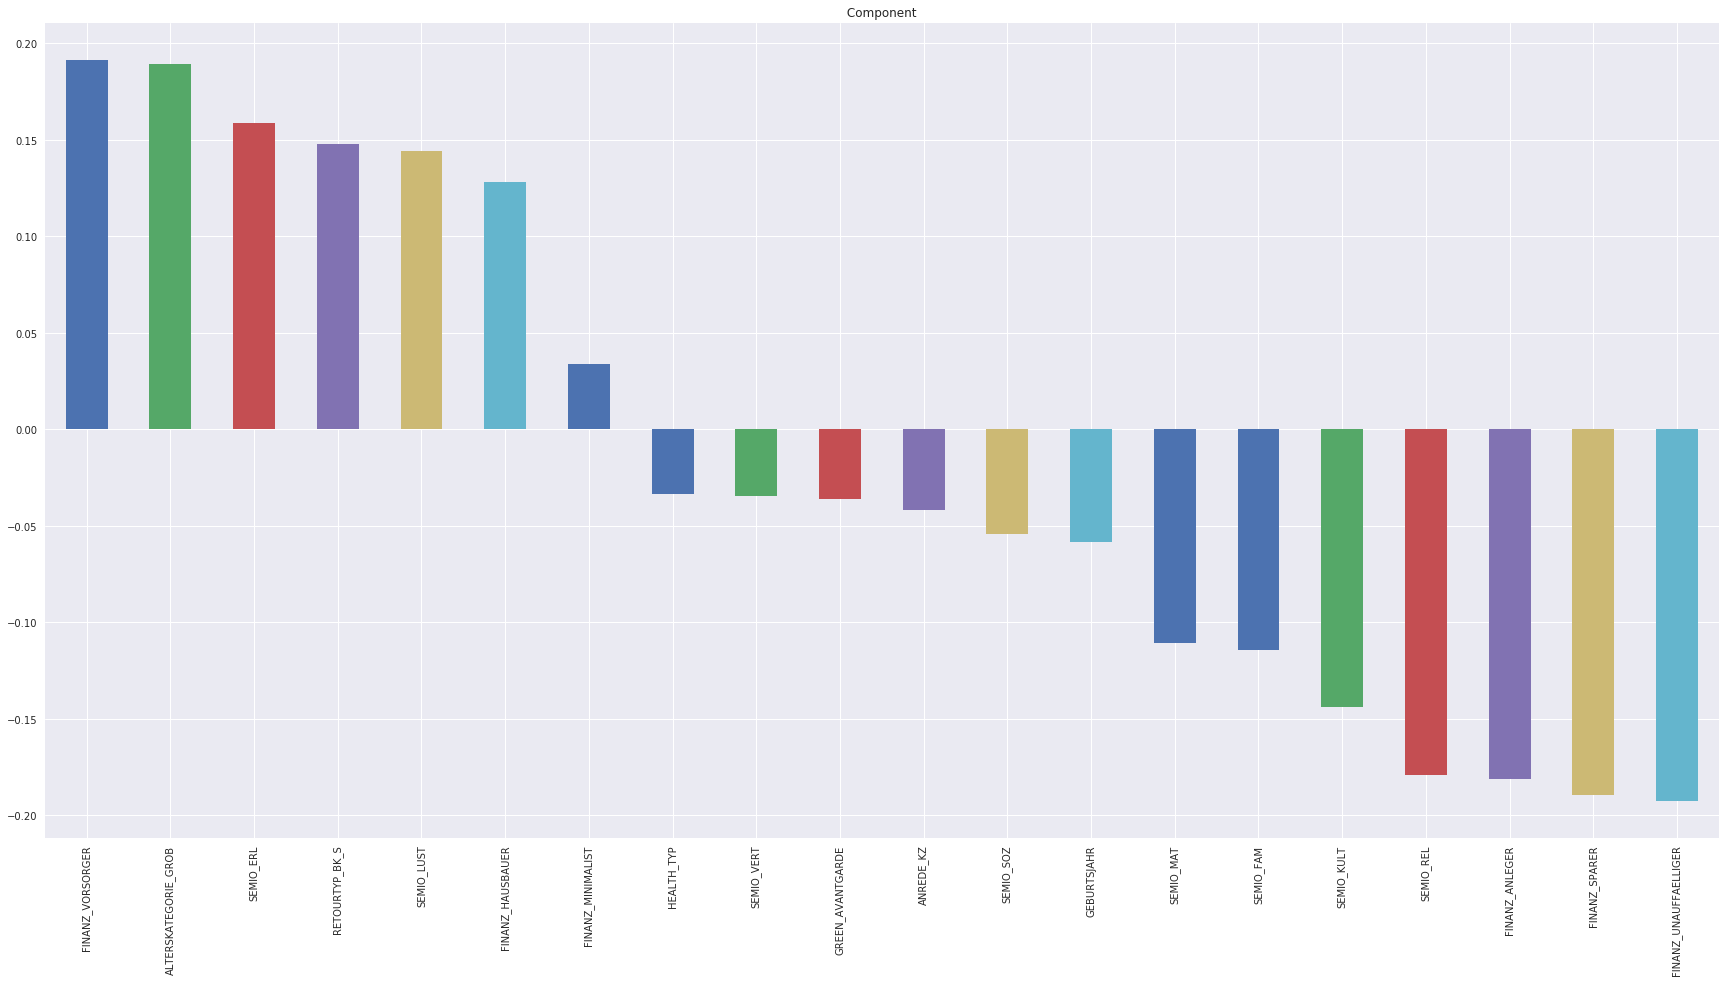

FINANZ_VORSORGER         0.191635
ALTERSKATEGORIE_GROB     0.189313
SEMIO_ERL                0.158988
RETOURTYP_BK_S           0.147929
SEMIO_LUST               0.144288
FINANZ_HAUSBAUER         0.128420
FINANZ_MINIMALIST        0.034022
HEALTH_TYP              -0.033375
SEMIO_VERT              -0.034472
GREEN_AVANTGARDE        -0.036025
ANREDE_KZ               -0.041976
SEMIO_SOZ               -0.054294
GEBURTSJAHR             -0.058247
SEMIO_MAT               -0.110438
SEMIO_FAM               -0.114088
SEMIO_KULT              -0.143568
SEMIO_REL               -0.179133
FINANZ_ANLEGER          -0.180875
FINANZ_SPARER           -0.189313
FINANZ_UNAUFFAELLIGER   -0.192423
Name: 1, dtype: float64

In [66]:
#Plot first component

PCA_weights(azdias_scaled, pca, 1)

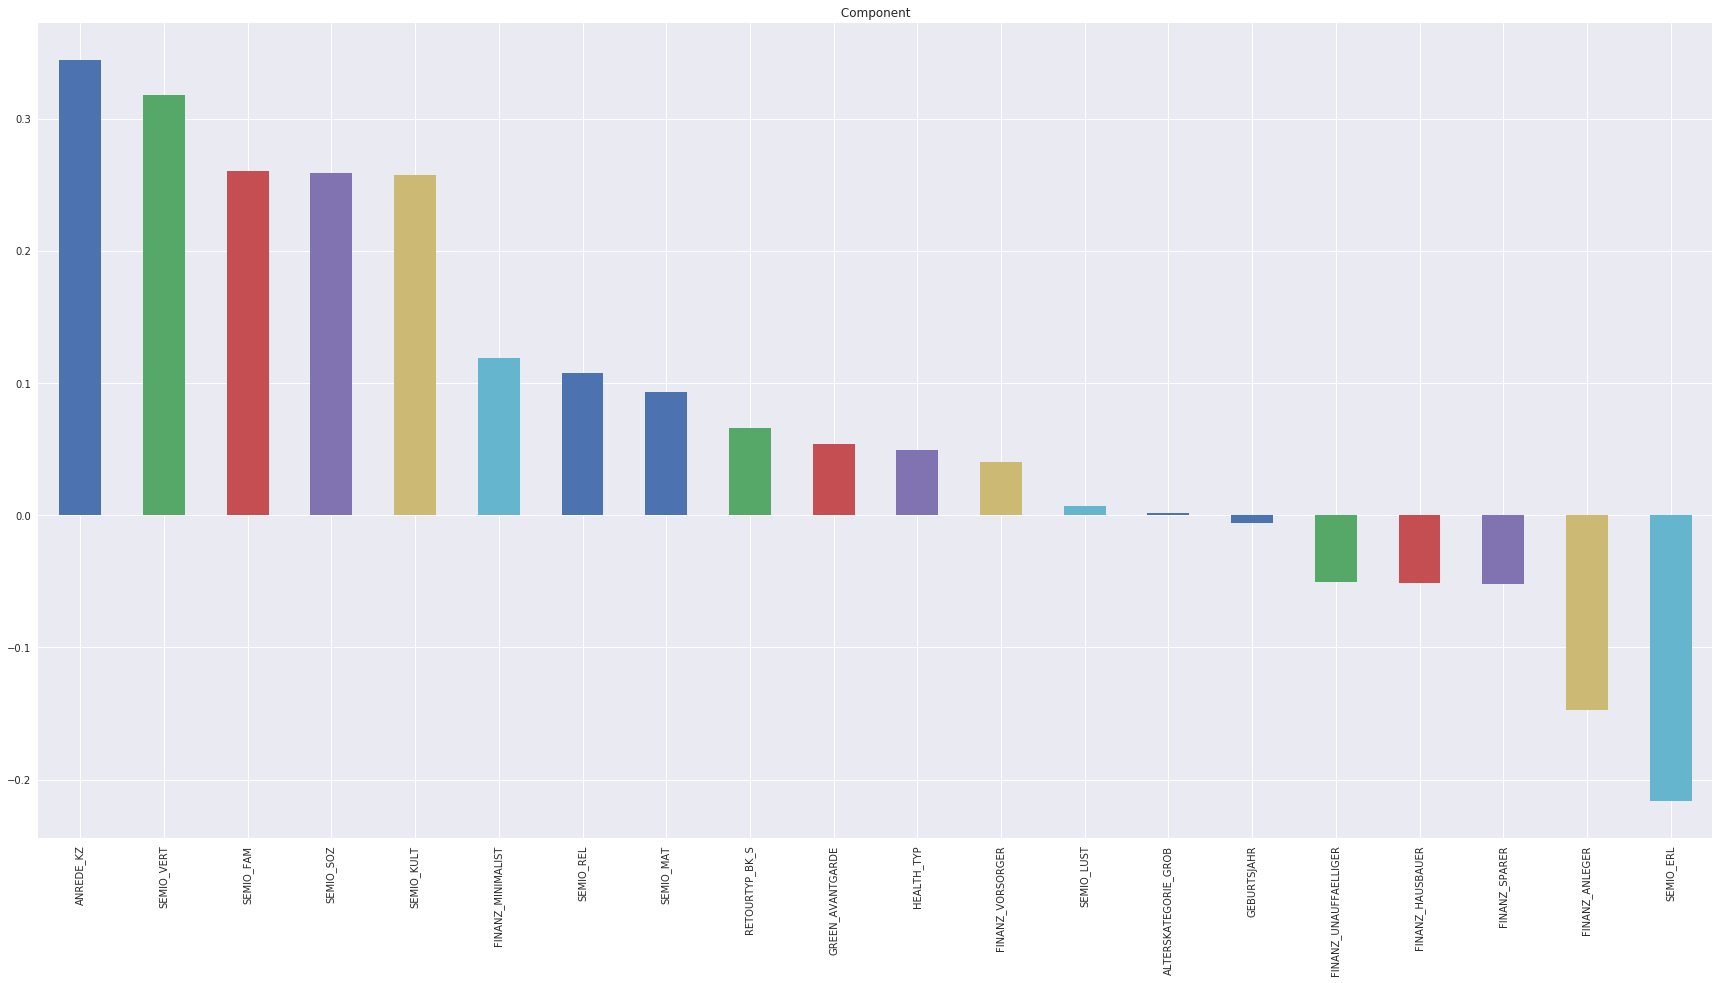

ANREDE_KZ                0.344561
SEMIO_VERT               0.317833
SEMIO_FAM                0.260428
SEMIO_SOZ                0.258641
SEMIO_KULT               0.257045
FINANZ_MINIMALIST        0.119107
SEMIO_REL                0.107904
SEMIO_MAT                0.092863
RETOURTYP_BK_S           0.066050
GREEN_AVANTGARDE         0.053679
HEALTH_TYP               0.049463
FINANZ_VORSORGER         0.040526
SEMIO_LUST               0.006899
ALTERSKATEGORIE_GROB     0.001545
GEBURTSJAHR             -0.005638
FINANZ_UNAUFFAELLIGER   -0.050134
FINANZ_HAUSBAUER        -0.051419
FINANZ_SPARER           -0.052136
FINANZ_ANLEGER          -0.147426
SEMIO_ERL               -0.215986
Name: 2, dtype: float64

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(azdias_scaled, pca, 2)

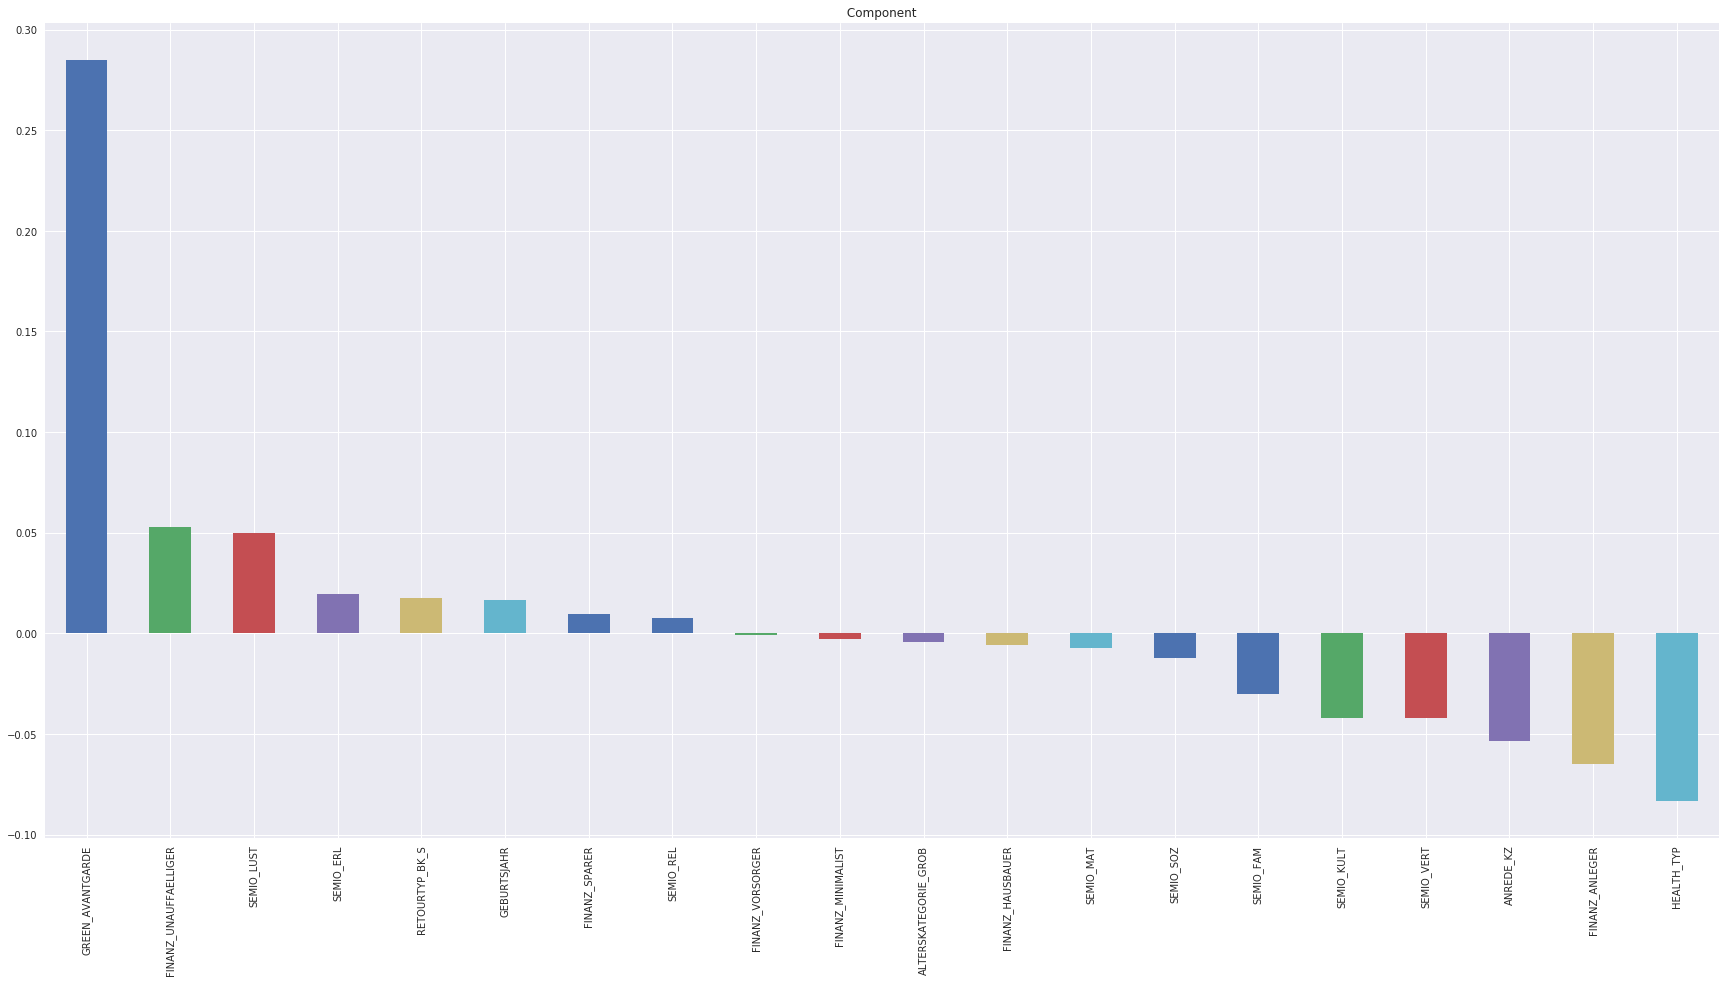

GREEN_AVANTGARDE         0.285107
FINANZ_UNAUFFAELLIGER    0.053029
SEMIO_LUST               0.049837
SEMIO_ERL                0.019479
RETOURTYP_BK_S           0.017430
GEBURTSJAHR              0.016531
FINANZ_SPARER            0.009810
SEMIO_REL                0.007695
FINANZ_VORSORGER        -0.000909
FINANZ_MINIMALIST       -0.003002
ALTERSKATEGORIE_GROB    -0.004417
FINANZ_HAUSBAUER        -0.005934
SEMIO_MAT               -0.007452
SEMIO_SOZ               -0.012059
SEMIO_FAM               -0.029967
SEMIO_KULT              -0.042013
SEMIO_VERT              -0.042179
ANREDE_KZ               -0.053696
FINANZ_ANLEGER          -0.065099
HEALTH_TYP              -0.083231
Name: 3, dtype: float64

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCA_weights(azdias_scaled, pca, 3)

### Discussion 2.3: Interpret Principal Components

Regarding finance, let's take the output of the first principal component as an example: 

FINANZ_VORSORGER         0.191635
FINANZ_HAUSBAUER         0.128420
FINANZ_MINIMALIST        0.034022
FINANZ_ANLEGER          -0.180875
FINANZ_SPARER           -0.189313
FINANZ_UNAUFFAELLIGER   -0.192423

Taking into consideration that the feature FINANZTYP has 6 types:
"Most descriptive financial type for individual
- -1: unknown
-  1: low financial interest (MINIMALIST)
-  2: money-saver (SPARER)
-  3: home ownership (HAUSBAUER)
-  4: be prepared (VORSORGER)
-  5: investor (ANLEGER)
-  6: inconspicuous (UNAUFFAELLIGER)"

"FINANZ_VORSORGER" and "FINANZ_SPARER " make the same impact on the variation on PC1. but in opposite directions which makes sense as the level of income of the individuals belonging to that group is opposing. 
FINANZ_UNAUFFAELLIGER makes a higher impact than FINANZ_SPARER
FINANZ_HAUSBAUER,FINANZ_ANLEGER and FINANZ_MINIMALIST also make an impact on the variation of PC1 but it's lower in magnitude.

The second factor playing an impact on the variation of PC1 is age(ALTERSKATEGORIE_GROB ). as it has the second highest weight on the variation of PCA.

I would also like to look at another example that has a low impact on the variation of PC1: "GREEN_AVANTGARDE" which is:
Membership in environmental sustainability as part of youth. It doesn't play much of an impact here but it does contribute to a higher impact on PC3.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [212]:
def get_kmeans(data,center):
    
    kmeans= MiniBatchKMeans(n_clusters= center, random_state=0, batch_size=10)
    model= kmeans.fit(data)
    score= np.abs(model.score(data))
    return score

In [213]:
scores=[]
centers= list(range(2,30,5))

for center in centers:
    scores.append(get_kmeans(X_pca, center))

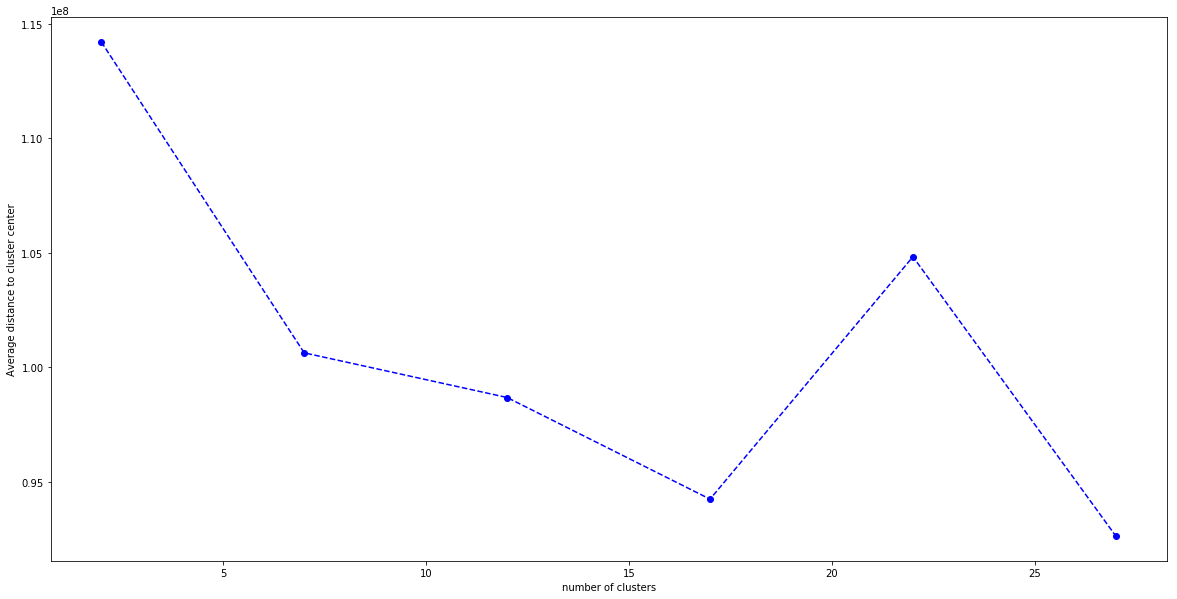

In [214]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(20,10))
ax = plt.subplot(111)
ax.set_xlabel('number of clusters')
ax.set_ylabel('Average distance to cluster center')
plt.plot(centers, scores, linestyle='--', marker='o', color='b')



In [215]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans= MiniBatchKMeans(n_clusters= 27, random_state=0, batch_size=10)
model= kmeans.fit(X_pca)
azdias_pred=model.predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population


I have decided to cluster the population into 27 clusters as this is the best number of clusters shown by the scores figure above as it is the beginning of the "elbow point". Increasing the number of clusters, wouldn't decrease the distance of points in cluster to center of cluster.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [256]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [257]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_df= clean_data(customers,feat_info)

number of rows  is 191652
number of columns is 85

number of rows  is 191652
number of columns is 78

number of rows  is 144967
number of columns is 78

AGER_TYP
0         2
2        -1
3         1
4        -1
5         1
6         2
7         1
8         2
9         1
10       -1
11        1
12       -1
13       -1
14        2
15        2
16        1
17       -1
18       -1
19       -1
20       -1
21        2
22        2
23       -1
24        2
25       -1
26        1
27       -1
28        2
29        0
30        2
         ..
191622    2
191623    1
191624    1
191625    2
191626   -1
191627    3
191628    1
191629    2
191630    2
191631    2
191632    0
191633    1
191634    2
191635    2
191636    2
191637   -1
191638    1
191639   -1
191640    3
191641    1
191642    2
191643    2
191644    2
191645    2
191646    3
191647    1
191648   -1
191649    2
191650    3
191651    3
Name: AGER_TYP, Length: 144967, dtype: int64
ANREDE_KZ
0         1
2         2
3         1
4         1
5  

In [228]:
#make sure there are no NaNs

customers_df.isnull().sum().sum()



0

In [258]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144967 entries, 0 to 191651
Columns: 206 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_XX
dtypes: float64(34), int64(26), uint8(146)
memory usage: 87.7 MB


In [391]:
#Scale data
scaler,customers_scaled= scale_features(customers_df)

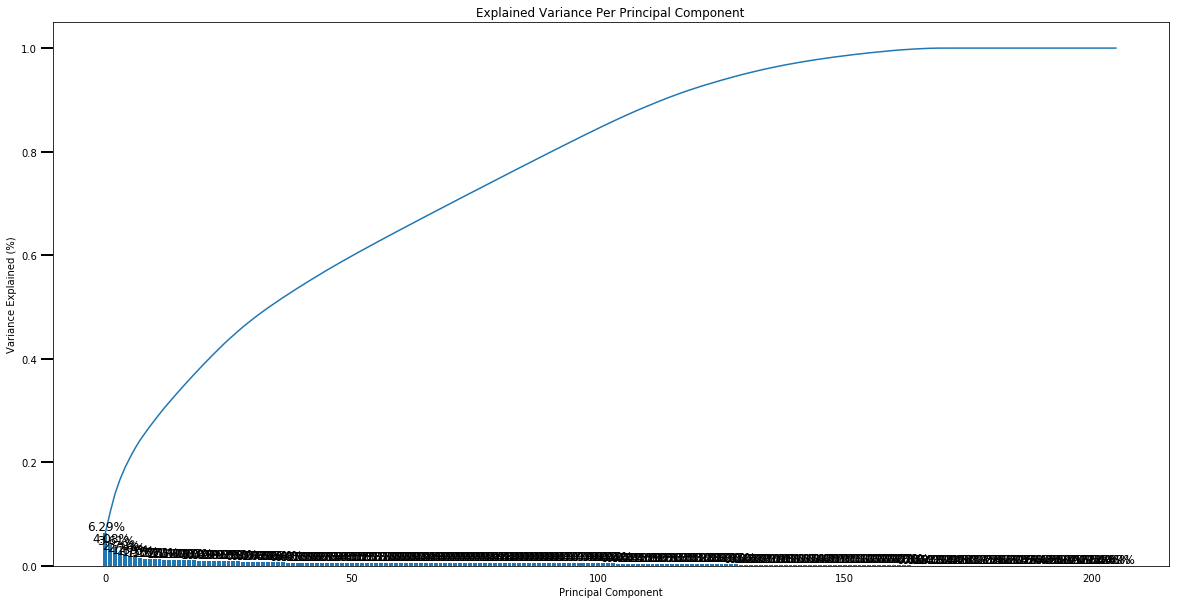

In [260]:
pca, X_pca= apply_pca(customers_scaled)
scree_plot(pca)

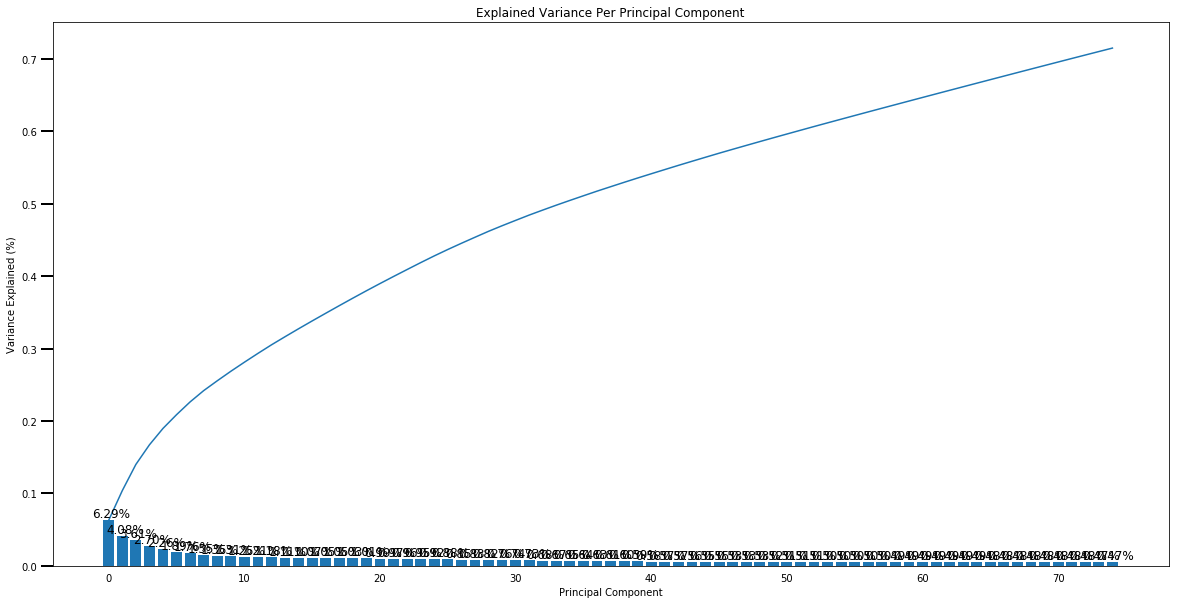

In [322]:
pca_cust, Y_pca= apply_pca2(75,customers_scaled)
scree_plot(pca_cust)

In [323]:
kmeans= kmeans= MiniBatchKMeans(n_clusters= 27, random_state=0, batch_size=10)
model= kmeans.fit(Y_pca)
customers_pred=model.predict(Y_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

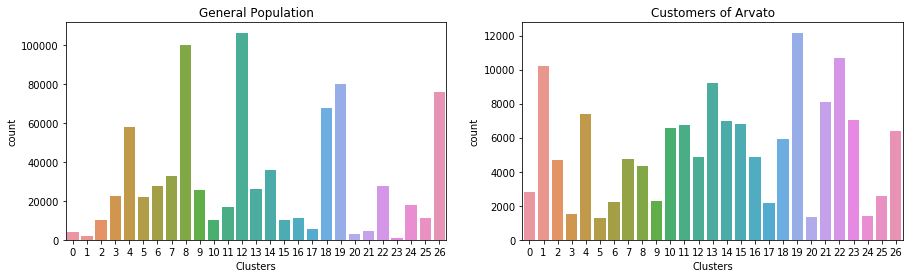

In [348]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def compare_data(general, customer):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)

    ax1.set_title('General Population')
    ax2.set_title('Customers of Arvato')
    ax1.set_xlabel('Clusters')
    ax2.set_xlabel('Clusters')
    
    sns.countplot(general,ax=ax1)            
    sns.countplot(customer,ax=ax2)
    
    plt.show()

compare_data(azdias_pred, customers_pred)

In [392]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

X= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[1])) #overepresented
Y= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[21])) #overepresented
attribute_vals_overep=pd.DataFrame({"feature":customers_df.columns,"cluster 1":X,"cluster 21":Y })

attribute_vals_overep.head(10)

,feature,cluster 1,cluster 21
0,ALTERSKATEGORIE_GROB,3.823706,3.705650
1,ANREDE_KZ,0.884312,0.973745
2,FINANZ_MINIMALIST,4.033813,2.689975
3,FINANZ_SPARER,1.069258,1.291432
4,FINANZ_VORSORGER,4.910717,4.779916
5,FINANZ_ANLEGER,1.626965,1.517112
6,FINANZ_UNAUFFAELLIGER,1.652890,1.472020
7,FINANZ_HAUSBAUER,3.426454,4.742919
8,GEBURTSJAHR,1328.601811,1328.601408
9,GREEN_AVANTGARDE,0.372674,0.086394


In [393]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

K= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[13])) #underpresented
Z= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[8])) #underpresented

attribute_vals_underp=pd.DataFrame({"feature":customers_df.columns,"cluster 13":K,"cluster 8":Z})

attribute_vals_underp.head(10)

,feature,cluster 13,cluster 8
0,ALTERSKATEGORIE_GROB,3.651492,3.698126
1,ANREDE_KZ,0.228663,0.209031
2,FINANZ_MINIMALIST,4.922438,4.730692
3,FINANZ_SPARER,1.133471,1.118294
4,FINANZ_VORSORGER,4.827635,4.847155
5,FINANZ_ANLEGER,1.325226,1.355702
6,FINANZ_UNAUFFAELLIGER,1.752116,2.215287
7,FINANZ_HAUSBAUER,2.147027,2.419170
8,GEBURTSJAHR,1325.376079,1272.443011
9,GREEN_AVANTGARDE,0.915999,0.409146


In [394]:
X= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[1])) #overepresented
Y= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[21])) #overepresented
K= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[13])) #underpresented
Z= scaler.inverse_transform(pca_cust.inverse_transform(model.cluster_centers_[8])) #underpresented
attribute_vals=pd.DataFrame({"feature":customers_df.columns,"cluster 1":X,"cluster 21":Y,"cluster 13":K,"cluster 8":Z })
attribute_vals.head(70)

,feature,cluster 1,cluster 21,cluster 13,cluster 8
0,ALTERSKATEGORIE_GROB,3.823706,3.705650,3.651492,3.698126
1,ANREDE_KZ,0.884312,0.973745,0.228663,0.209031
2,FINANZ_MINIMALIST,4.033813,2.689975,4.922438,4.730692
3,FINANZ_SPARER,1.069258,1.291432,1.133471,1.118294
4,FINANZ_VORSORGER,4.910717,4.779916,4.827635,4.847155
5,FINANZ_ANLEGER,1.626965,1.517112,1.325226,1.355702
6,FINANZ_UNAUFFAELLIGER,1.652890,1.472020,1.752116,2.215287
7,FINANZ_HAUSBAUER,3.426454,4.742919,2.147027,2.419170
8,GEBURTSJAHR,1328.601811,1328.601408,1325.376079,1272.443011
9,GREEN_AVANTGARDE,0.372674,0.086394,0.915999,0.409146


### Discussion 3.3: Compare Customer Data to Demographics Data


Since clusters 1 and 21 are overrepresented in the customer base of the company, we can interpret that the mail company is highly popular with customers who are: 

- 46-60 Years old since ALTERSKATEGORIE_GRO =3.823706 and 3.7 
- male since ANREDE_KZ	= 0.9
- are high income earners since LP_LEBENSPHASE_GROB= 3.7, 3.5 
- are financially prepared since FINANZ_VORSORGER= 4.9, 4.7
- socially minded since SEMIO_SOZ	3.163726	
- family oriented since SEMIO_FAM	2.167272	


Since clusters 13 and 8 are underrepresented in the customer base of the company, we can interpret that the mail company is less popular with customers who are: 

- gender: can't be determined since ANREDE_KZ	= 0.028
- high-income earner families and single parents since LP_LEBENSPHASE_GROB= 8.4, 6.3
- Low financial interest since FINANZ_MINIMALIST= 4.922438	4.730692
- religous since SEMIO_REL	3.17


## References:
 - https://github.com/WejdanCS/Identify-customer-segments/blob/master/Identify_Customer_Segments.ipynb
 - https://towardsdatascience.com/customer-segmentation-report-for-arvato-financial-solutions-b08a01ac7bc0
 - Udacity's helperfunctions.py (scree plot)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.